In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import os
import torchvision
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import time
import math
import numpy as np
from typing import Callable

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        self.channels = channels
        self.query:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        self.key:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        self.value:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        self.gamma:nn.Parameter = nn.Parameter(torch.zeros(1))
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        q:torch.Tensor = self.query(x).view(B, C, H * W).permute(0, 2, 1)
        k:torch.Tensor = self.key(x).view(B, C, H * W)
        v:torch.Tensor = self.value(x).view(B, C, H * W)
        
        attn:torch.Tensor = torch.bmm(q, k) / (C ** 0.5)
        attn = F.softmax(attn, dim=-1)
        out:torch.Tensor = torch.bmm(v, attn.permute(0, 2, 1)).view(B, C, H, W)
        
        return self.gamma * out + x

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.norm1:nn.GroupNorm = nn.GroupNorm(min(32, in_channels), in_channels)
        self.conv1:nn.Conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm2:nn.GroupNorm = nn.GroupNorm(min(32, out_channels), out_channels)
        self.conv2:nn.Conv2d = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_mlp:nn.Linear = nn.Linear(time_emb_dim, out_channels)
        self.residual:nn.Conv2d = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        h:torch.Tensor = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.norm2(h)
        h = F.silu(h)
        h += self.time_mlp(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.residual(x)

class UNet(nn.Module):
    def __init__(self, in_channels:int=3, base_channels:int=64, time_emb_dim:int=128, device:str="cpu") -> None:
        super().__init__()
        self.in_channels:int = in_channels
        self.base_channels:int = base_channels
        self.time_emb_dim:int = time_emb_dim
        self.device:str = device
        
        self.time_mlp:nn.Sequential = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        self.encoder:nn.ModuleList = nn.ModuleList([
            ResBlock(in_channels, base_channels, time_emb_dim), # 3 -> 64
            ResBlock(base_channels, base_channels * 2, time_emb_dim), # 64 -> 128
            SelfAttention(base_channels * 2),
            ResBlock(base_channels * 2, base_channels * 4, time_emb_dim), # 128 -> 256
            SelfAttention(base_channels * 4)
        ])
        
        self.middle:ResBlock = ResBlock(base_channels * 4, base_channels * 4, time_emb_dim) # 256 -> 256
        
        self.decoder:nn.ModuleList = nn.ModuleList([
            ResBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim),  # 512 -> 128
            SelfAttention(base_channels * 2),
            ResBlock(base_channels * 2 + base_channels * 2, base_channels, time_emb_dim),  # 256 -> 64
            SelfAttention(base_channels),
            ResBlock(base_channels + base_channels, in_channels, time_emb_dim)  # 128 -> 3
        ])

    def _get_timestep_embedding(self, t:torch.Tensor) -> torch.Tensor:
        """
        Convert a tensor of timesteps t of shape (batch_size, 1) into sinusoidal embeddings of shape (batch_size, time_emb_dim)
        """
        half_dim = self.time_emb_dim // 2
        emb = torch.log(torch.tensor(10000.0, device=self.device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=self.device, dtype=torch.float32) * -emb)
        emb = t.float() * emb
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], -1)
        return emb
        
    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        t_emb:torch.Tensor = self._get_timestep_embedding(t)
        t_emb = self.time_mlp(t_emb)
        
        skips:list[torch.Tensor] = list[torch.Tensor]()
        for layer in self.encoder:
            x = layer(x, t_emb) if isinstance(layer, ResBlock) else layer(x)
            skips.append(x)

        x = self.middle(x, t_emb)
        
        for layer in self.decoder:
            skip = skips.pop()
            if isinstance(layer, ResBlock):
                x = torch.cat([x, skip], dim=1)
                x = layer(x, t_emb)
            else:
                x = layer(x)
        
        return x

In [3]:
def quadratic_schedule(timesteps:int) -> torch.Tensor:
    return torch.linspace(1e-4, math.sqrt(0.02), timesteps, requires_grad=False) ** 2

def polynomial_schedule(timesteps:int, deg:float) -> torch.Tensor:
    return torch.linspace(1e-4, math.pow(0.02, 1.0 / deg), timesteps, requires_grad=False) ** deg

def linear_schedule(timesteps:int) -> torch.Tensor:
    return torch.linspace(1e-4, 0.02, timesteps, requires_grad=False)

def cosine_schedule(timesteps:int) -> torch.Tensor:
    s:float = 0.008  # Small offset to avoid extreme values
    t:torch.Tensor = torch.linspace(0, timesteps, timesteps + 1, requires_grad=False)
    alpha_bar:torch.Tensor = torch.cos(((t / timesteps) + s) / (1 + s) * (np.pi / 2)) ** 2
    betas:torch.Tensor = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return torch.clamp(betas, 0, 0.999)  # Ensure valid values

def sigmoid_based_schedule(timesteps:int, final_alpha_bar:float=0.2, curve_exponent:float=2.0) -> torch.Tensor:
    t:torch.Tensor = torch.linspace(0.0, 1.0, timesteps + 1, requires_grad=False)
    alpha_bar:torch.Tensor = final_alpha_bar + (1.0 - final_alpha_bar) * ((1.0 - t) ** curve_exponent)
    betas_inverted:torch.Tensor = 1.0 - (alpha_bar[1:] / alpha_bar[:-1])
    betas = torch.ones(betas_inverted.shape, requires_grad=False)
    for i in range(0, betas_inverted.shape[0]):
        betas[i] = betas_inverted[betas_inverted.shape[0] - i - 1]

    return torch.clamp(betas, 1e-4, final_alpha_bar)

# N = 1000
# beta:torch.Tensor = sigmoid_based_schedule(N)
# alpha:torch.Tensor = 1.0 - beta
# alpha_bar:torch.Tensor = torch.cumprod(alpha, dim=0)
# X:list[int] = [i for i in range(0, beta.shape[0])]
# plt.plot(X, [beta[i] for i in range(beta.shape[0])], label="beta")
# plt.plot(X, [alpha[i] for i in range(alpha.shape[0])], label="alpha")
# plt.plot(X, [alpha_bar[i] for i in range(beta.shape[0])], label="alpha_bar")
# plt.legend()
# plt.show()

In [14]:
class DiffusionModel:
    def __init__(self, model:UNet, optimizer:torch.optim.Optimizer, criterion:_Loss, scheduler:Callable[[int], torch.Tensor], timesteps:int=1000, noise_standard_deviation:float=0.5, device:str="cpu") -> None:
        self.model:UNet = model.to(device)
        self.optimizer:torch.optim.Optimizer = optimizer
        self.criterion:_Loss = criterion
        self.scheduler:Callable[[int], torch.Tensor] = scheduler
        self.timesteps:int = timesteps
        self.noise_standard_deviation = noise_standard_deviation
        self.device:str = device
        self.beta_schedule:torch.Tensor = self.scheduler(timesteps)
        self.alpha:torch.Tensor = 1.0 - self.beta_schedule
        self.alpha_bar:torch.Tensor = torch.cumprod(self.alpha, dim=0)
    
    def _generate_gaussian_noise(self, shape:tuple[int]) -> torch.Tensor:
        return torch.clamp(torch.randn(shape, requires_grad=False) * self.noise_standard_deviation, -1.0, 1.0)

    #x0.shape : (batch_size, in_channels, base_channels, base_channels)
    #t.shape : (batch_size)
    def add_noise(self, x0:torch.Tensor, t:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        with torch.no_grad():
            noise:torch.Tensor = self._generate_gaussian_noise(x0.shape)
            alpha_bar_t:torch.Tensor = self.alpha_bar[t].view(-1, 1, 1, 1)
            return (torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise).to(self.device), noise.to(self.device)
    
    def train_step(self, x0:torch.Tensor, perform_SGD:bool = True) -> tuple[float, torch.Tensor, torch.Tensor, torch.Tensor]:

        def train(x0:torch.Tensor):
            batch_size:int = x0.shape[0]
            t:torch.Tensor = torch.randint(0, self.timesteps, (batch_size,))
            xt, noise = self.add_noise(x0, t)
            xt_detach:torch.Tensor = xt.detach().cpu().clone()
            noise_detach:torch.Tensor = noise.detach().cpu().clone()
            t = t.float().unsqueeze(1).to(self.device)

            self.optimizer.zero_grad()
            pred_noise:torch.Tensor = self.model(xt, t)
            pred_noise_detach:torch.Tensor = pred_noise.detach().cpu().clone()
            loss:torch.Tensor = self.criterion(pred_noise, noise)
            if perform_SGD:
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                self.optimizer.step()

            if self.device != "cpu":
                del x0
                del xt
                del t
                del noise
                torch.cuda.empty_cache()

            return loss.detach().cpu().item(), xt_detach, pred_noise_detach, noise_detach
        
        if perform_SGD:
            return train(x0)
        with torch.no_grad():
            return train(x0)
    
    def sample(self, nb_sample:int, verbose:bool = False) -> torch.Tensor:
        with torch.no_grad():
            x:torch.Tensor =  self._generate_gaussian_noise((nb_sample, self.model.in_channels, self.model.base_channels, self.model.base_channels)).to(self.device)
            for i, t in enumerate(reversed(range(0, self.timesteps))):
                t_tensor:torch.Tensor = (torch.ones((nb_sample, 1), device=self.device) * t).float()
                pred_noise:torch.Tensor = self.model(x, t_tensor)
                alpha_t:float = self.alpha[t]
                alpha_bar_t:float = self.alpha_bar[t]
                beta_t:float = self.beta_schedule[t]
                noise:torch.Tensor = None
                if t > 0:
                    noise = self._generate_gaussian_noise(x.shape).to(self.device)
                else:
                    noise = torch.zeros(x.shape, device=self.device)
                x = 1.0 / torch.sqrt(alpha_t) * (x - ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)) * pred_noise) + torch.sqrt(beta_t) * noise

                if verbose and i % 100 == 0:
                    image:torch.Tensor = x[0].detach().cpu() * 0.5 + 0.5
                    plt.imshow(torch.clamp(image.permute(1, 2, 0), 0.0, 1.0))
                    plt.show()

        return torch.clamp(x * 0.5 + 0.5, 0.0, 1.0).cpu()

In [5]:
def load_dataset() -> list[torch.Tensor]:
    images_dir:str = os.path.join(os.getcwd(), "Dataset", "64x64")
    images_path:list[str] = os.listdir(images_dir)
    images:list[torch.Tensor] = list[torch.Tensor]()

    for image_local_path in images_path:
        image_absolute_path:str = os.path.join(images_dir, image_local_path)
        image:torch.Tensor = torchvision.io.read_image(image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        image = image * 2.0 - 1.0 # Extend the image for the [-1, 1] range
        images.append(image)

    return images

dataset:list[torch.Tensor] = load_dataset()

In [6]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)
        image:torch.Tensor = dataset[index] * 0.5 + 0.5
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
        
# plot_dataset_image(1)

In [7]:
class UNetSetting:
    in_channels:int=3
    base_channels:int=64
    time_emb_dim:int=128

    def __init__(self, in_channels:int=3, base_channels:int=64, time_emb_dim:int=128) -> None:
        self.in_channels = in_channels
        self.base_channels = base_channels
        self.time_emb_dim = time_emb_dim

#training params
unet_setting = UNetSetting(3, 64, 128)
lr:float = 0.0001
batch_size:int = 48
timestep:int = 1000
scheduler:Callable[[int], torch.Tensor] = lambda n : sigmoid_based_schedule(n, 0.2, 2.0)
time_embedding_dim:int = 128
noise_standard_deviation:float = 0.33
epochs:int = 16
test_proportion:float = 0.1
saving_model:bool = True
print_epoch_interval:int = 1
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cuda


In [8]:
class TrainResult:
    denoiser:UNet
    train_losses:list[float]
    test_losses:list[float]

    def __init__(self, denoiser:UNet, train_losses:list[float], test_losses:list[float]) -> None:
        self.denoiser = denoiser
        self.train_losses = train_losses
        self.test_losses = test_losses

In [9]:
def load_denoiser(file:str) -> UNet:
    model:UNet = UNet(unet_setting.in_channels, unet_setting.base_channels, unet_setting.time_emb_dim, device)
    model_path:str = os.path.join(os.getcwd(), "Models", file)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

denoiser = load_denoiser("denoiser.model")

param_size = 0
for param in denoiser.parameters():
    param_size += param.nelement() * param.element_size()

size_all_mb = (param_size + 0) / (1024**2)
print("Model size: {:.3f} MB with {} parameters".format(size_all_mb, sum(p.numel() for p in denoiser.parameters())))

Model size: 14.639 MB with 3837613 parameters


Start training UNet


Training model:   6%|▋         | 1154/18464 [32:30<7:29:32,  1.56s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08134055..1.0790854].


Noisy image :


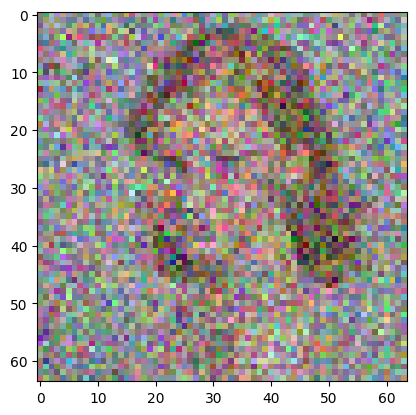

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09485066..1.0567931].


Predict image :


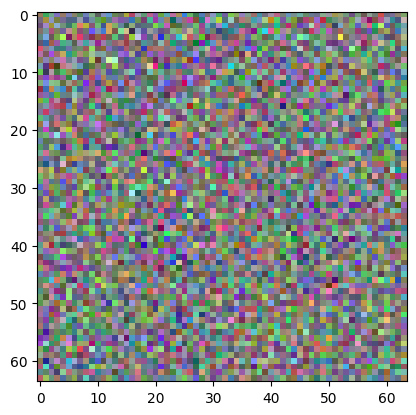

Added noise :


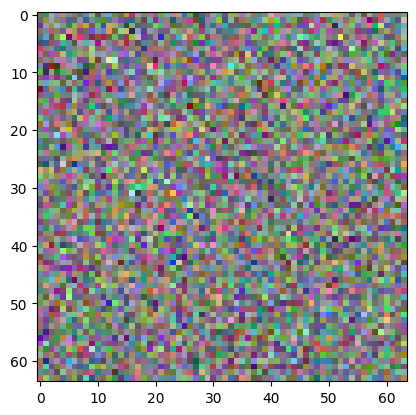

Epoch 1, Loss: 0.03220410085891727
Denoiser Saved!


Training model:  12%|█▎        | 2308/18464 [1:04:23<6:46:33,  1.51s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18748921..1.1306143].


Noisy image :


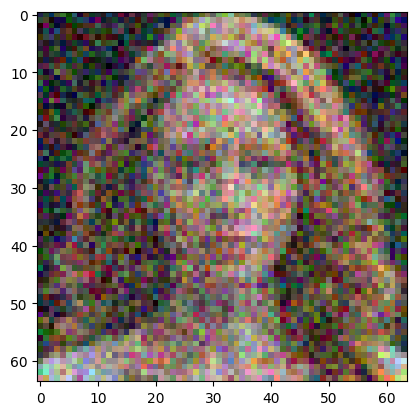

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061834216..0.9969286].


Predict image :


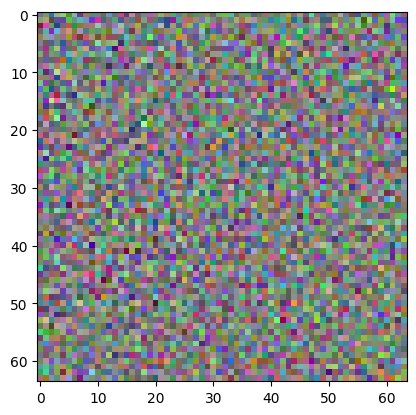

Added noise :


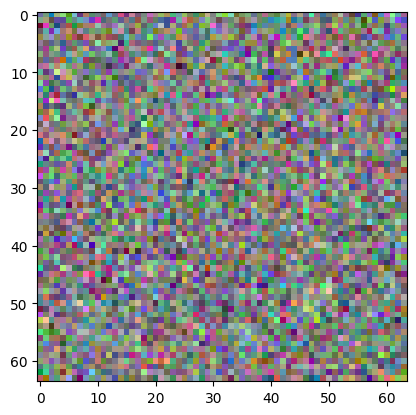

Epoch 2, Loss: 0.016875139826608487
Denoiser Saved!


Training model:  19%|█▉        | 3462/18464 [1:37:06<6:21:59,  1.53s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17737532..1.0472959].


Noisy image :


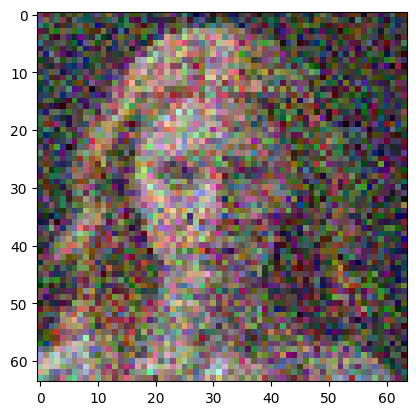

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021717131..1.0161769].


Predict image :


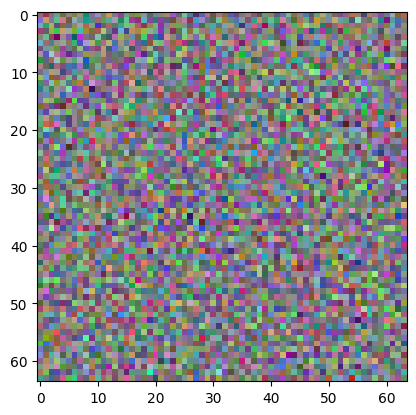

Added noise :


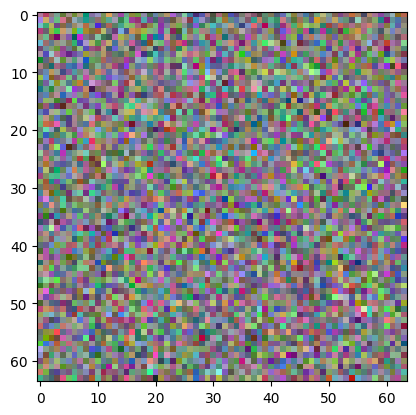

Epoch 3, Loss: 0.014424934298884723
Denoiser Saved!


Training model:  25%|██▌       | 4616/18464 [2:09:42<5:47:45,  1.51s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1197474..1.1306009].


Noisy image :


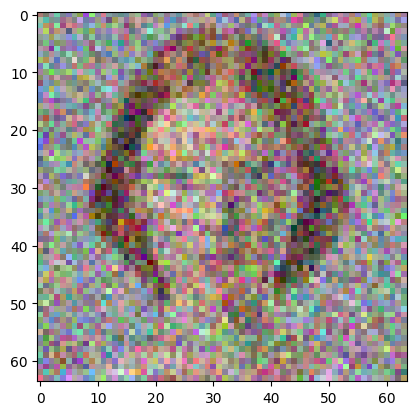

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06917375..0.998572].


Predict image :


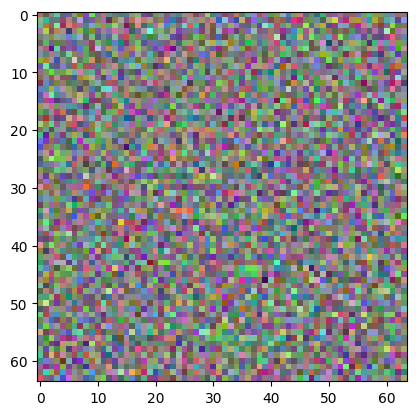

Added noise :


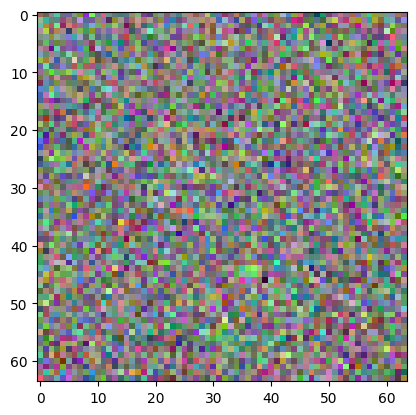

Epoch 4, Loss: 0.013703282263962812
Denoiser Saved!


Training model:  31%|███▏      | 5770/18464 [2:42:22<5:24:12,  1.53s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18386549..1.1208029].


Noisy image :


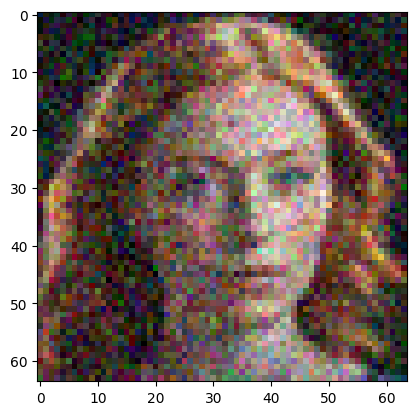

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08377004..1.0229092].


Predict image :


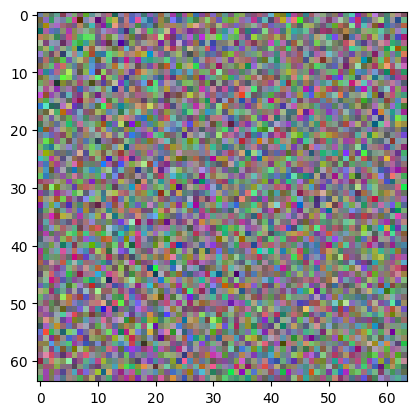

Added noise :


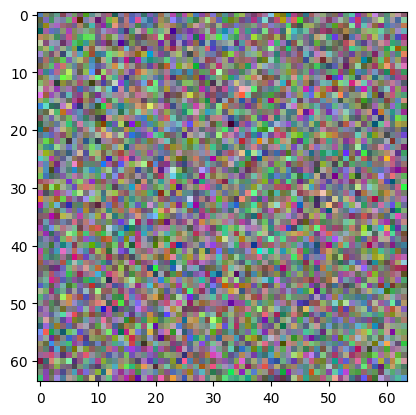

Epoch 5, Loss: 0.014092397906751318
Denoiser Saved!


Training model:  38%|███▊      | 6924/18464 [3:15:35<4:57:46,  1.55s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1678387..1.1288538].


Noisy image :


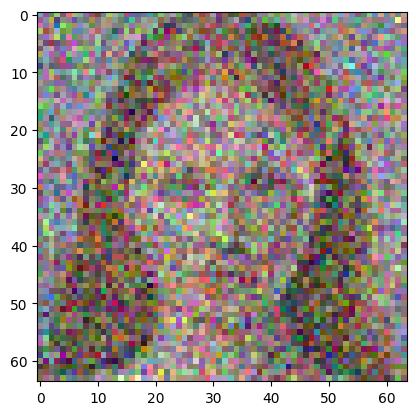

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039595187..1.0591748].


Predict image :


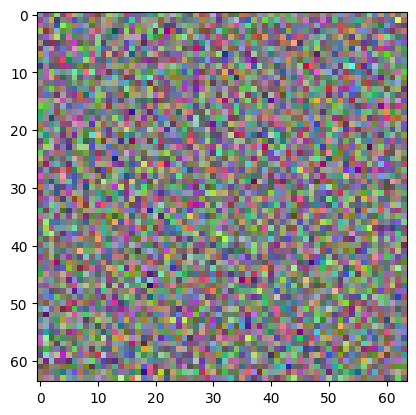

Added noise :


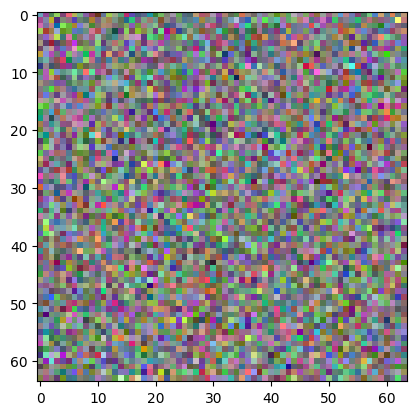

Epoch 6, Loss: 0.01422212791969706
Denoiser Saved!


Training model:  44%|████▍     | 8078/18464 [3:48:08<4:19:58,  1.50s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17257416..1.1350322].


Noisy image :


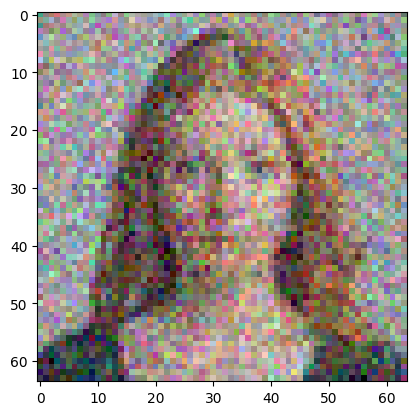

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.064781725..1.0211117].


Predict image :


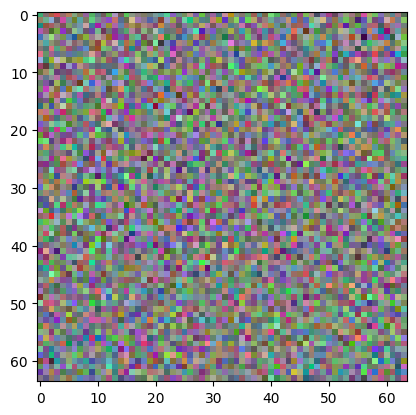

Added noise :


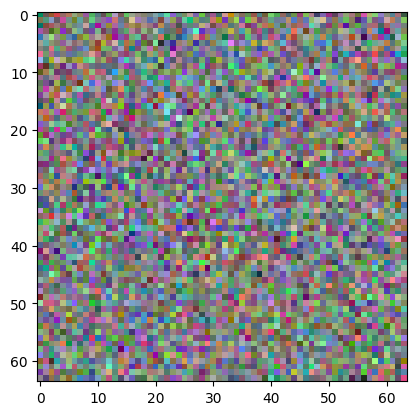

Epoch 7, Loss: 0.013989846430318607
Denoiser Saved!


Training model:  50%|█████     | 9232/18464 [4:20:42<3:58:14,  1.55s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04587996..0.974788].


Noisy image :


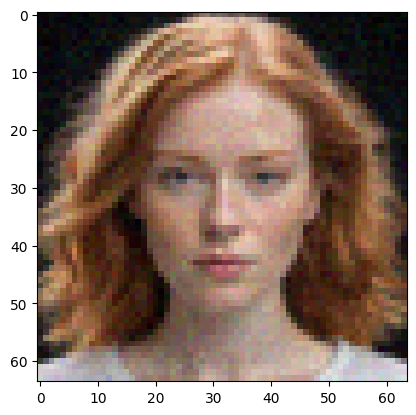

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011165738..1.1061625].


Predict image :


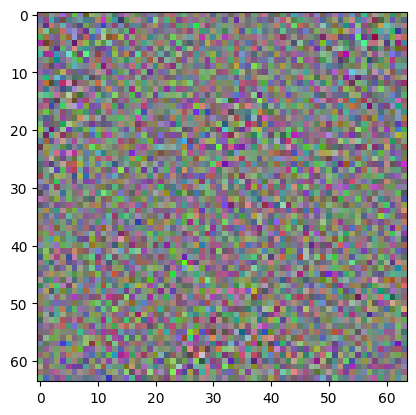

Added noise :


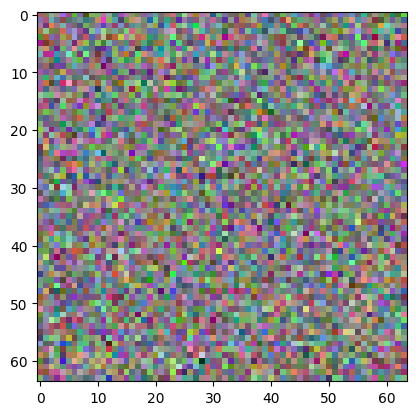

Epoch 8, Loss: 0.014252558634640646
Denoiser Saved!


Training model:  56%|█████▋    | 10386/18464 [4:53:39<3:25:43,  1.53s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11851752..1.0789135].


Noisy image :


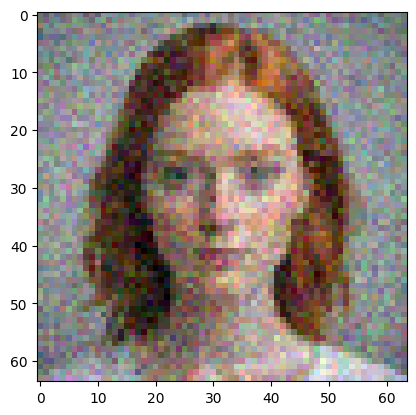

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.096512854..1.0903699].


Predict image :


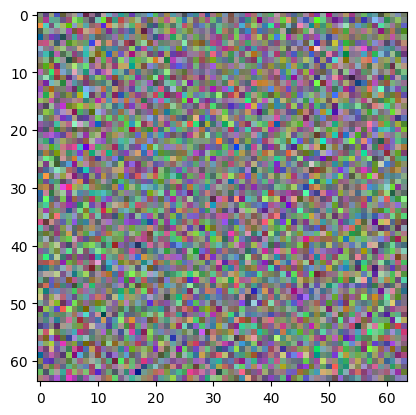

Added noise :


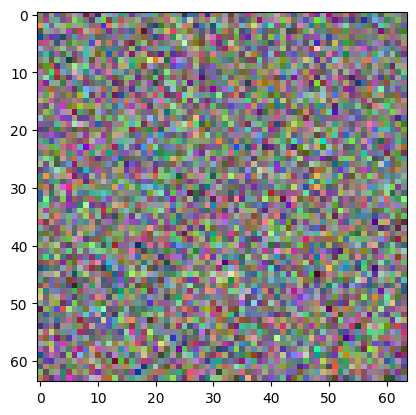

Epoch 9, Loss: 0.01278267629070133
Denoiser Saved!


Training model:  62%|██████▎   | 11540/18464 [5:26:32<2:54:17,  1.51s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15263629..1.0582383].


Noisy image :


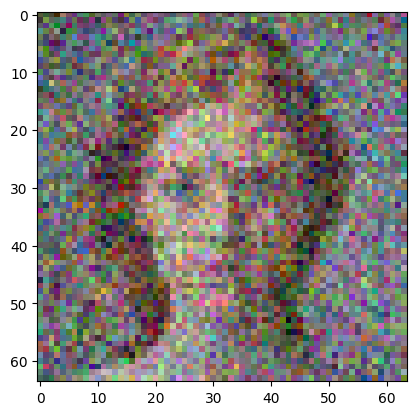

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04684955..1.0185299].


Predict image :


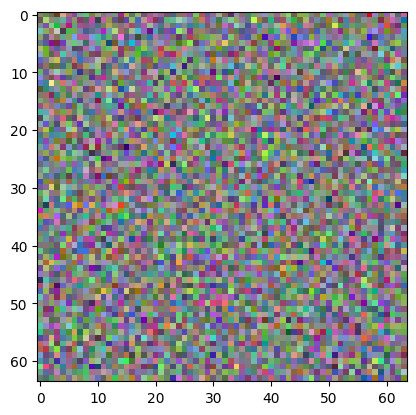

Added noise :


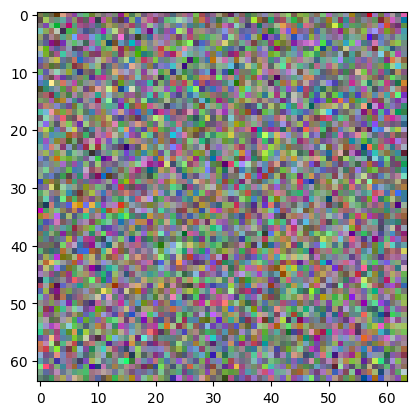

Epoch 10, Loss: 0.012737181876984584
Denoiser Saved!


Training model:  69%|██████▉   | 12694/18464 [5:59:04<2:27:31,  1.53s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.090467155..1.029283].


Noisy image :


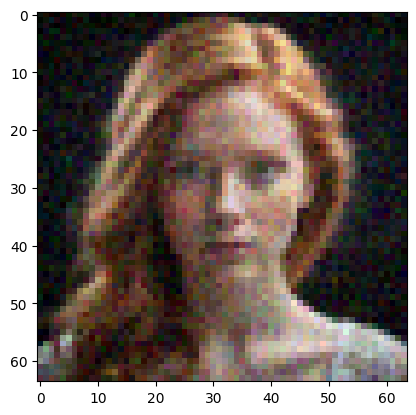

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.079702616..1.073174].


Predict image :


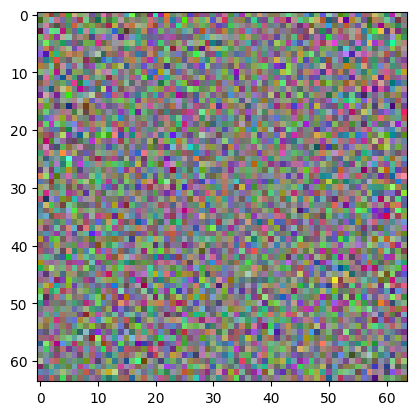

Added noise :


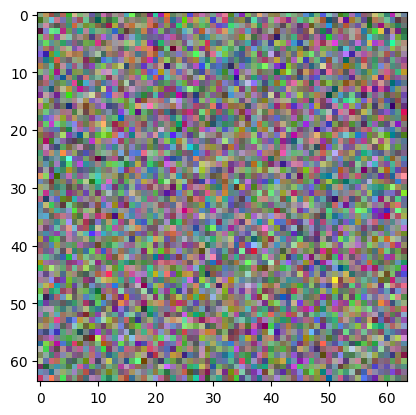

Epoch 11, Loss: 0.012688264973861918
Denoiser Saved!


Training model:  75%|███████▌  | 13848/18464 [6:32:04<1:58:44,  1.54s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1086663..1.1037035].


Noisy image :


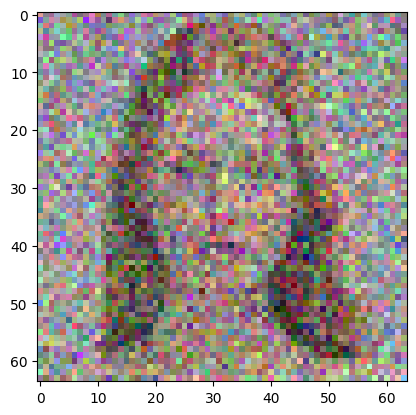

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045210004..1.0491867].


Predict image :


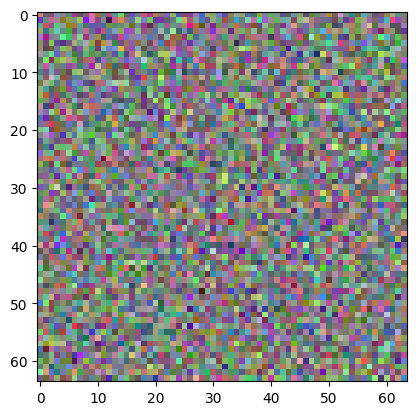

Added noise :


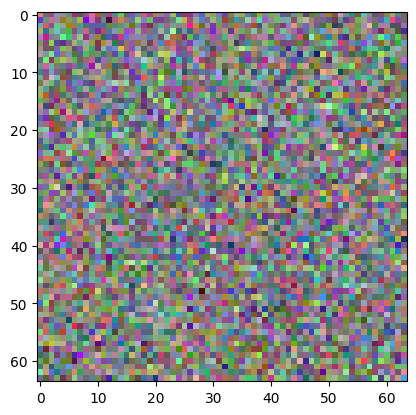

Epoch 12, Loss: 0.011941765026678451
Denoiser Saved!


Training model:  81%|████████▏ | 15002/18464 [7:04:35<1:27:57,  1.52s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14640903..1.1368866].


Noisy image :


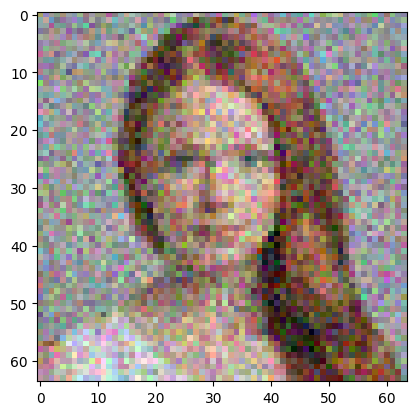

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.052459955..1.0470556].


Predict image :


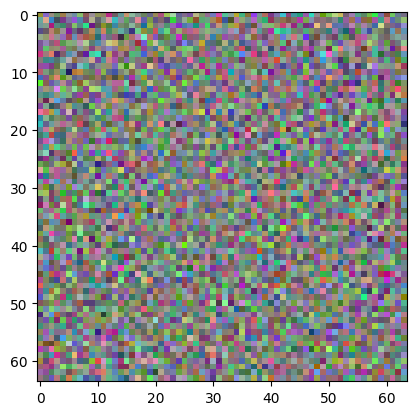

Added noise :


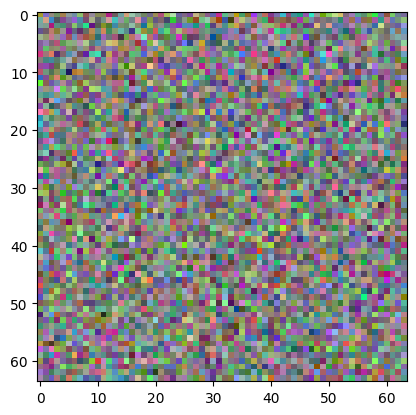

Epoch 13, Loss: 0.011832172906533064
Denoiser Saved!


Training model:  88%|████████▊ | 16156/18464 [7:38:35<1:03:48,  1.66s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08216047..1.0653678].


Noisy image :


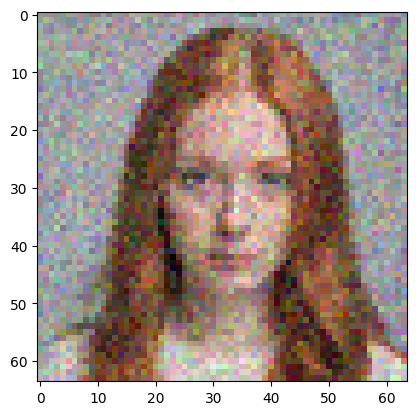

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044350803..1.0189239].


Predict image :


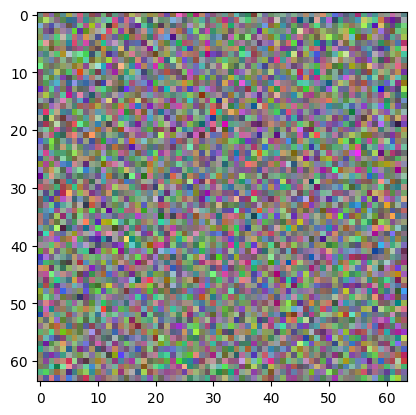

Added noise :


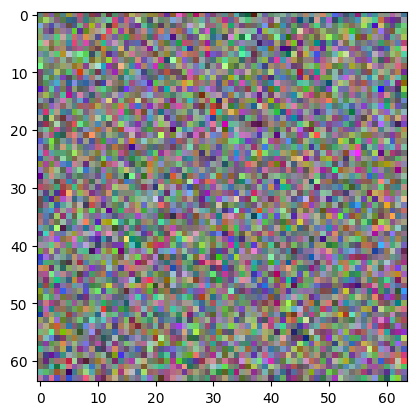

Epoch 14, Loss: 0.01227182885906312
Denoiser Saved!


Training model:  94%|█████████▍| 17310/18464 [8:11:54<30:18,  1.58s/it]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13437617..1.0795593].


Noisy image :


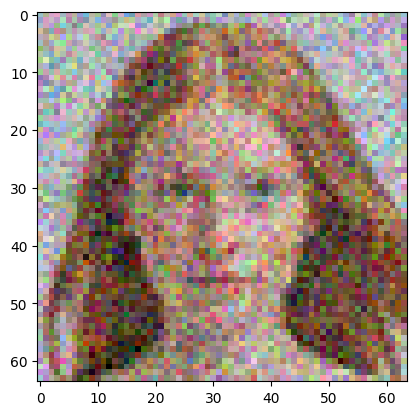

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05379474..1.0119232].


Predict image :


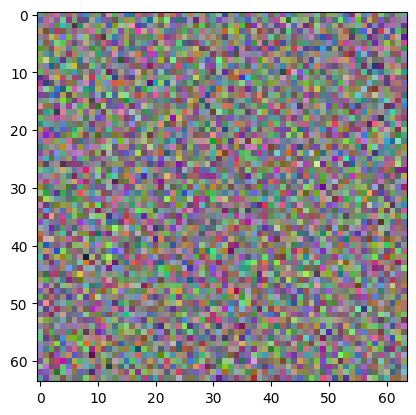

Added noise :


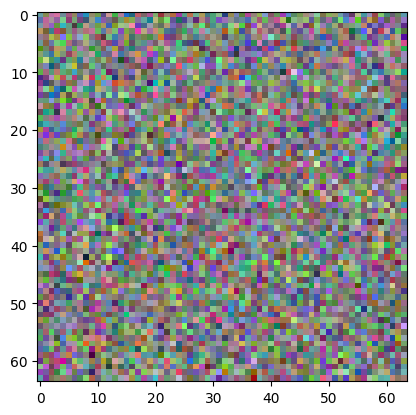

Epoch 15, Loss: 0.01214336183574212
Denoiser Saved!


Training model: 100%|██████████| 18464/18464 [8:44:47<00:00,  1.54s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13452333..1.0422741].


Noisy image :


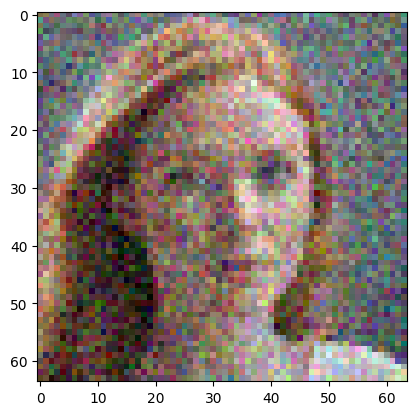

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.080257356..0.994558].


Predict image :


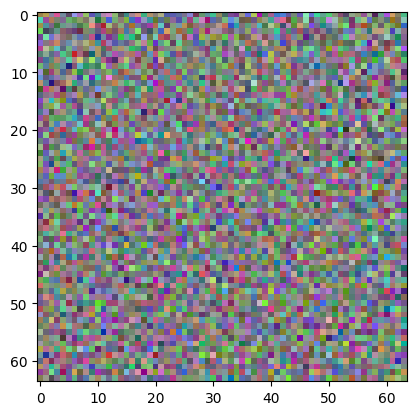

Added noise :


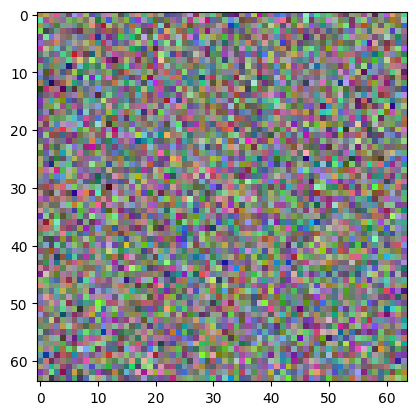

Epoch 16, Loss: 0.012653310800962266
Denoiser Saved!


Training model: 100%|██████████| 18464/18464 [8:47:57<00:00,  1.72s/it]


In [ ]:
def train_denoiser(model:UNet, train_dataset:list[torch.Tensor], test_dataset:list[torch.Tensor]) -> TrainResult:

    sample_to_print = min(nb_sample_to_print, batch_size)
    test_dataset_tensor:torch.Tensor = torch.stack(test_dataset).cpu()
    train_dataset_tensor:torch.Tensor = torch.stack(train_dataset).cpu()

    optimizer:torch.optim.Adam = torch.optim.Adam(model.parameters(), lr = lr)#,  weight_decay=1e-5) #weight_decay for L2 regularization
    criterion:nn.MSELoss = nn.MSELoss()
    diffusion:DiffusionModel = DiffusionModel(model, optimizer, criterion, scheduler, timestep, noise_standard_deviation, device)

    train_losses:list[float] = list[float]()
    test_losses:list[float] = list[float]()

    print("Start training UNet")
    with tqdm.tqdm(total=epochs * len(train_dataset), desc="Training model") as pbar:
        for epoch in range(0, epochs):
            train_loader:DataLoader = DataLoader(train_dataset_tensor, batch_size, shuffle=True)
            input_batch:torch.Tensor = None
            total_loss:float = 0.0

            last_noisy_images_batch:torch.Tensor = None
            last_pred_noise_batch:torch.Tensor = None
            last_noise_batch:torch.Tensor = None
            for input_batch in train_loader:
                loss, noisy_images_batch, pred_noise_batch, noise_batch = diffusion.train_step(input_batch)

                last_noisy_images_batch = noisy_images_batch
                last_pred_noise_batch = pred_noise_batch
                last_noise_batch = noise_batch

                total_loss += loss

                pbar.update(input_batch.shape[0])

            print_sample = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)
            if print_sample:
                for i in range(0, sample_to_print):
                    noisy_image:torch.Tensor = last_noisy_images_batch[i] * 0.5 + 0.5
                    pred_noise:torch.Tensor = last_pred_noise_batch[i] * 0.5 + 0.5
                    noise:torch.Tensor = last_noise_batch[i] * 0.5 + 0.5
                    print("Noisy image :")
                    plt.imshow(noisy_image.permute(1, 2, 0))
                    plt.show()
                    print("Predict image :")
                    plt.imshow(pred_noise.permute(1, 2, 0))
                    plt.show()
                    print("Added noise :")
                    plt.imshow(noise.permute(1, 2, 0))
                    plt.show()

            train_loss:float = total_loss / (len(train_dataset) / batch_size)
            train_losses.append(train_loss)
            print(f"Epoch {epoch+1}, Loss: {train_loss}")

            if saving_model:
                path:str = f"./Models/denoiser_epoch{epoch}.model" if epoch < epochs - 1 else "./Models/denoiser.model"
                if os.path.isfile(path):
                    os.remove(path)

                torch.save(model.state_dict(), path)
                print(f"Denoiser Saved!")

            total_loss = 0.0
            test_loader:DataLoader = DataLoader(test_dataset_tensor, batch_size, shuffle=True)
            for input_batch in test_loader:
                loss, noisy_images_batch, pred_noise_batch, noise_batch = diffusion.train_step(input_batch)
                total_loss += loss
            test_losses.append(total_loss / (len(test_dataset_tensor) / batch_size))

        return TrainResult(model, train_losses, test_losses)

train_dataset:list[torch.Tensor] = None
test_dataset:list[torch.Tensor] = None
train_dataset, test_dataset = train_test_split(dataset, test_size = test_proportion, random_state=42, shuffle=True)

denoiser:UNet = UNet(unet_setting.in_channels, unet_setting.base_channels, unet_setting.time_emb_dim, device)
# denoiser:UNet = load_denoiser("denoiser_epoch13.model")
train_result:TrainResult = train_denoiser(denoiser, train_dataset, test_dataset)
denoiser = train_result.denoiser

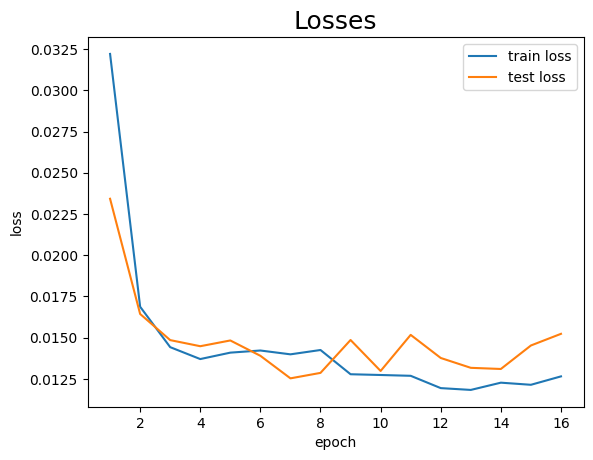

In [12]:
def show_training_result(train_result:TrainResult) -> None:
    X:list[float] = [float(i) for i in range(1, epochs + 1)]
    plt.plot(X, train_result.train_losses, label='train loss')
    plt.plot(X, train_result.test_losses, label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

show_training_result(train_result)

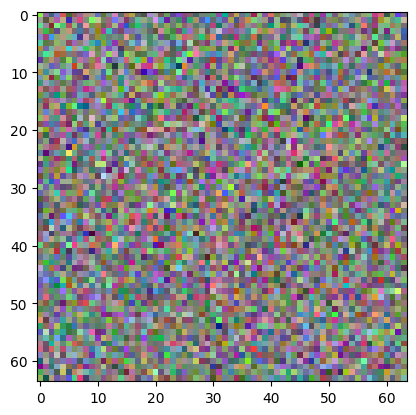

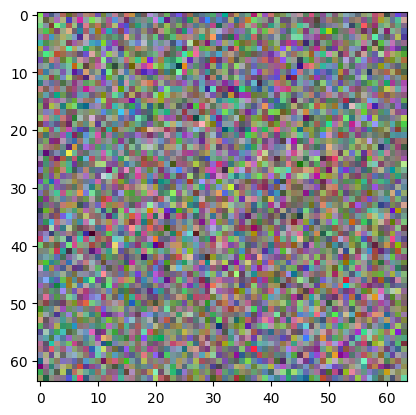

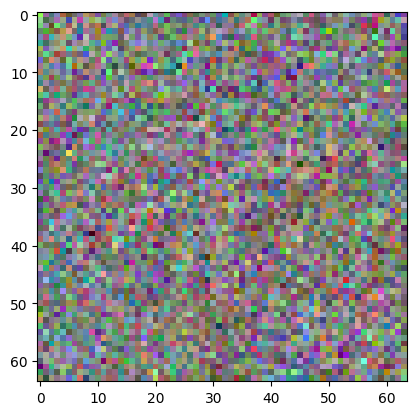

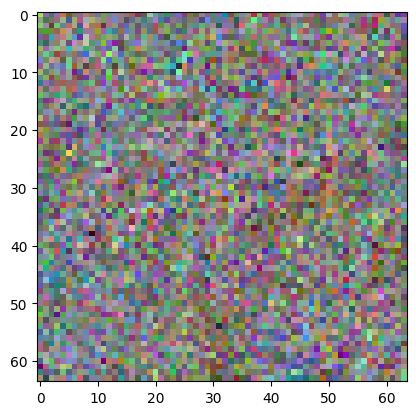

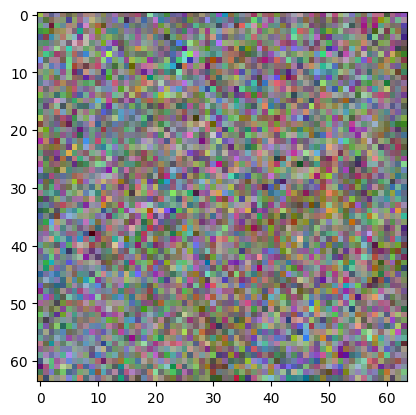

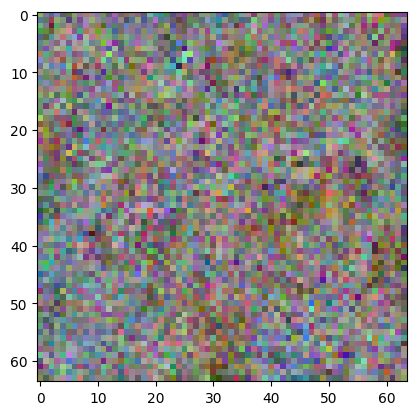

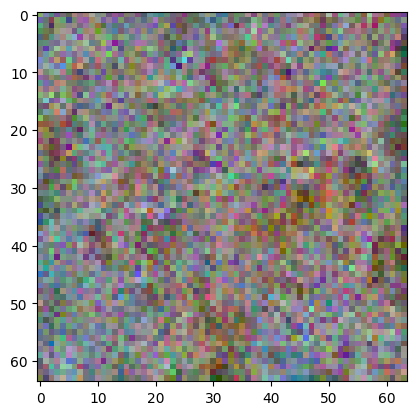

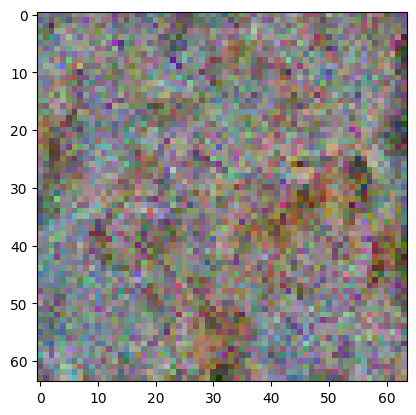

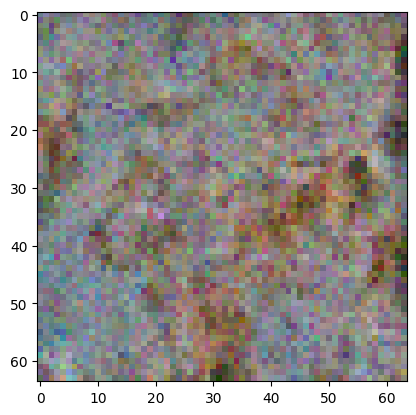

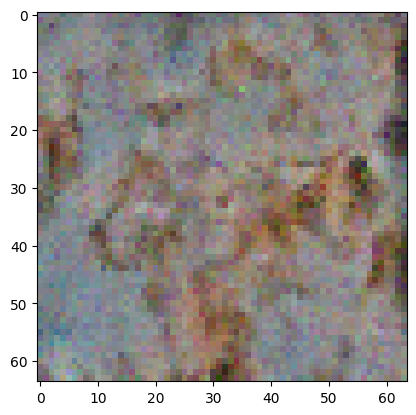

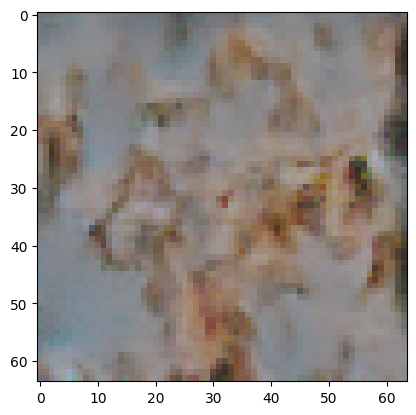

In [17]:
def generate_image(model:DiffusionModel, verbose:bool=False) -> torch.Tensor:
    return model.sample(1, verbose)[0].permute(1, 2, 0)

denoiser = load_denoiser("denoiser_epoch4.model")
diffusion:DiffusionModel = DiffusionModel(denoiser, None, None, scheduler, timestep, noise_standard_deviation, device)
image:torch.Tensor = generate_image(diffusion, True)
plt.imshow(image)
plt.show()